In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.tree import DecisionTreeRegressor

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay

import klib
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r"C:\Users\Saidabrorkhon\ML_Lectures\ML 2nd month\datasets\energy_consumption.csv")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Building Type        1000 non-null   object 
 1   Square Footage       999 non-null    float64
 2   Number of Occupants  1000 non-null   object 
 3   Appliances Used      1000 non-null   object 
 4   Average Temperature  1000 non-null   float64
 5   Day of Week          1000 non-null   object 
 6   Energy Consumption   1000 non-null   float64
dtypes: float64(3), object(4)
memory usage: 54.8+ KB


In [12]:
df.head()

,Building Type,Square Footage,Number of Occupants,Appliances Used,Average Temperature,Day of Week,Energy Consumption
0,Residential,7063.0,76,10,29.84,Weekday,2713.95
1,Commercial,44372.0,66,45,16.72,Weekday,5744.99
2,Industrial,19255.0,37,17,14.30,Weekend,4101.24
3,Residential,13265.0,14,41,32.82,Weekday,3009.14
4,Commercial,13375.0,26,18,11.92,Weekday,3279.17


GridSpec(6, 6)

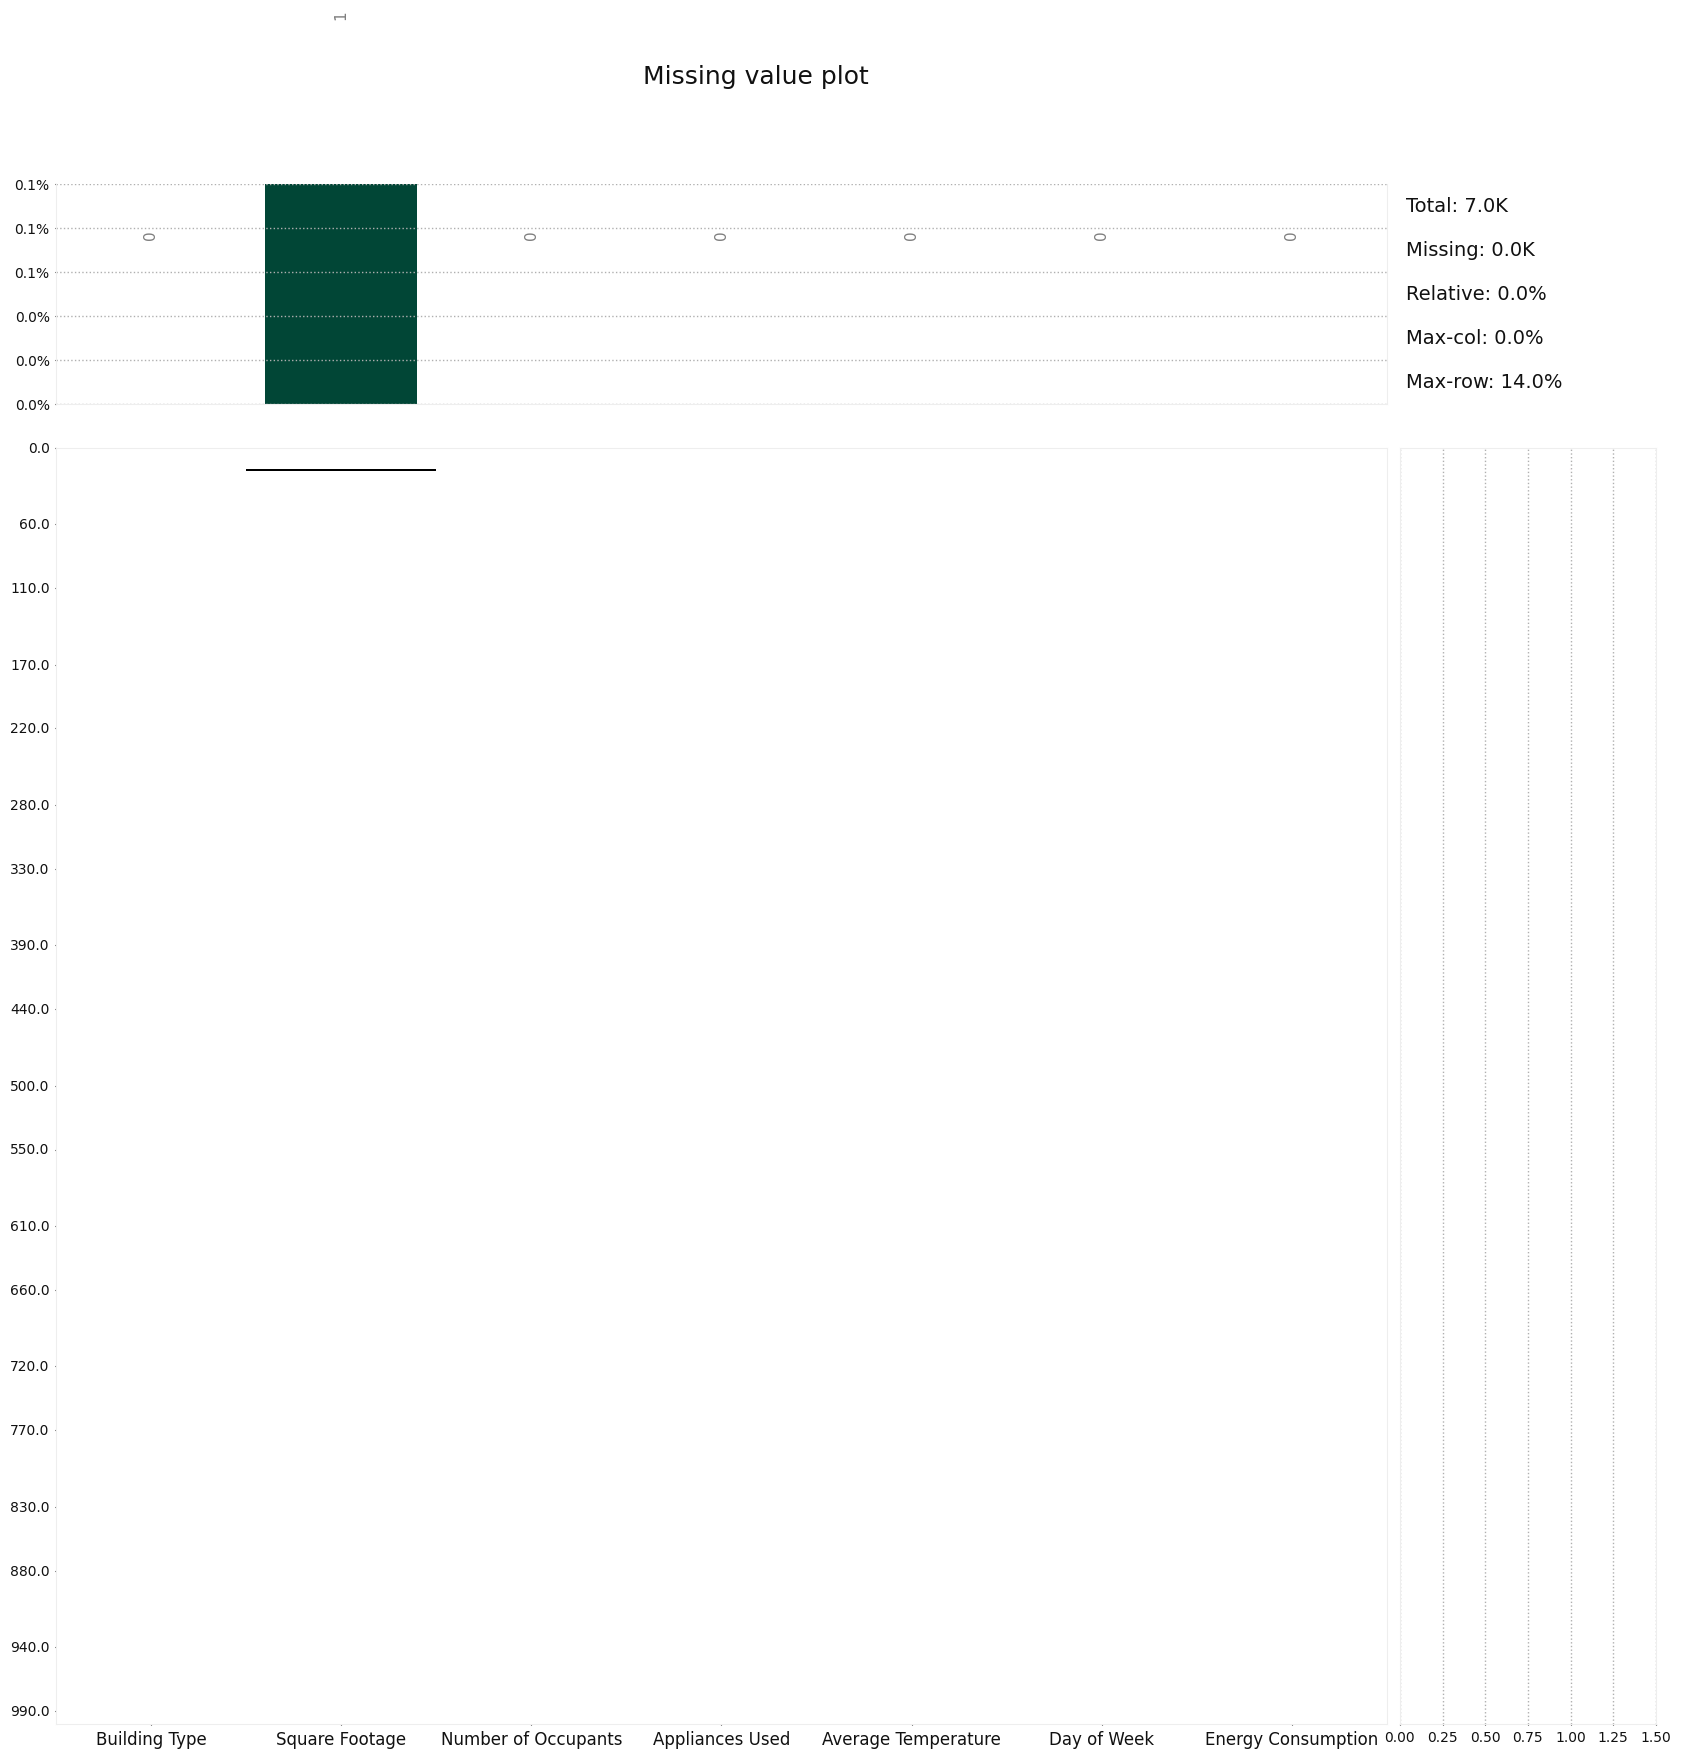

In [9]:
klib.missingval_plot(df)

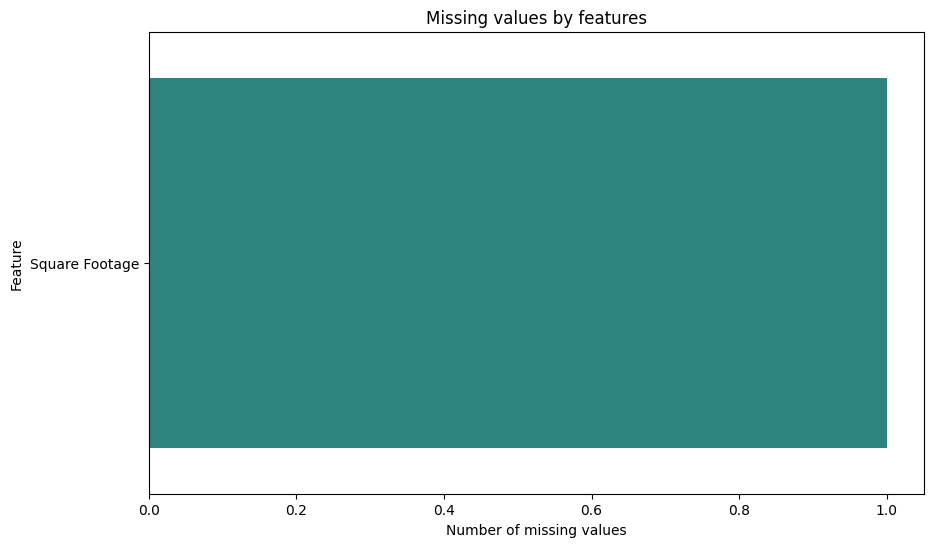

In [10]:
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=missing.values, y=missing.index, palette='viridis')
plt.title('Missing values by features')
plt.xlabel('Number of missing values')
plt.ylabel('Feature')
plt.show()

In [12]:
import plotly.express as px

In [19]:
value_counts = df['Square Footage'].isnull().value_counts().rename(index={True: 'Missing', False: 'Not Missing'}).reset_index()
value_counts.columns = ['Status', 'Count']

px.pie(value_counts, names='Status', values='Count', title='Missing vs Not Missing - Square Footage')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Building Type        1000 non-null   object 
 1   Square Footage       1000 non-null   float64
 2   Number of Occupants  1000 non-null   object 
 3   Appliances Used      1000 non-null   object 
 4   Average Temperature  1000 non-null   float64
 5   Day of Week          1000 non-null   object 
 6   Energy Consumption   1000 non-null   float64
dtypes: float64(3), object(4)
memory usage: 54.8+ KB


In [9]:
cat_cols = df.select_dtypes(include='object').columns
num_cols = df.select_dtypes(include='number').columns.drop('Energy Consumption')

In [10]:
numerical_features = Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='mean')),
  ('scaler', StandardScaler())
])

categorical_features = Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='most_frequent')),
  ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
  ('num', numerical_features, num_cols),
  ('cat', categorical_features, cat_cols)
])

model = DecisionTreeRegressor()

model_pipeline = Pipeline(steps=[
  ('preprocessor', preprocessor),
  ('model', DecisionTreeRegressor())
])

In [11]:
param_gird = {
  'model__max_depth': [3,5,10,None],
  'model__min_samples_split': [2,5,10],
  'model__min_samples_leaf': [1,2,5],
  'model__max_features': ['sqrt','log2',None]
}

grid_search = GridSearchCV(
  estimator=model_pipeline,
  param_grid=param_gird,
  cv=5,
  n_jobs=-1,
  scoring='r2'
)

In [12]:
x = df.drop(columns=['Energy Consumption'])
y = df['Energy Consumption']
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.2, random_state=42)


In [13]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Square Footage', 'Average Temperature'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['Building Type', 'Number of Occupants', 'Appliances Used',
       'Day of Week'],
      dtype='object'))])),
                                       ('model', DecisionTreeRegressor())]),
             n_jobs=-1,
             param_grid={'model__max_depth': [3, 5, 10, None],
                         'model__max_features': ['sqrt', 'log2', None],
                         'model__min_samples_leaf': [1, 2, 5],
                         'model__min_samples_split': [2, 5, 10]},
             scoring='r2')

In [14]:
y_pred = grid_search.predict(x_val)

In [16]:
r2 = r2_score(y_val, y_pred)
r2

0.7265083008464372

In [17]:
mse = mean_squared_error(y_val, y_pred)
mse

199790.47508637182

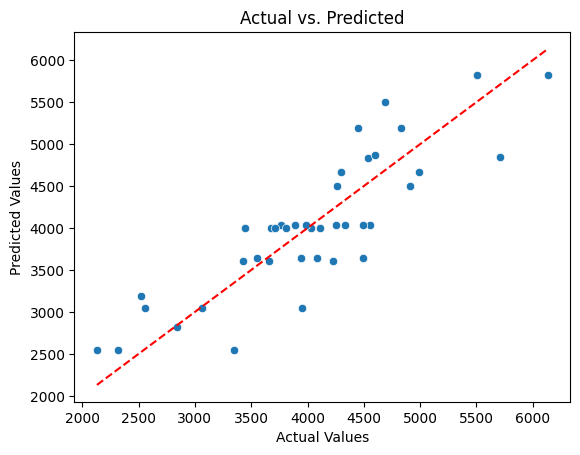

In [ ]:
sns.scatterplot(x=y_val, y=y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.show()

In [27]:
from tabulate import tabulate
headers=['Model', 'R2_score', 'MSE']
data = [['DecisionTreeRegressor', r2, mse]]
result = tabulate(data, headers=headers, tablefmt='grid')
print(result)

+-----------------------+------------+--------+
| Model                 |   R2_score |    MSE |
+=======================+============+========+
| DecisionTreeRegressor |   0.726508 | 199790 |
+-----------------------+------------+--------+
